In [1]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import ipdb
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from torch.utils import data as data_
import torch
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import vis_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

/datasets/home/98/898/cjgunthe/Fast-Pedestrian-Tracking/utils/vis_tool.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/si

In [2]:
import requests

from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
                        bar.update(CHUNK_SIZE)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

# Download Models from Google Drive

In [3]:
if not os.path.isdir("checkpoints"):
    os.mkdir("checkpoints")

# Download Baseline Model
download_file_from_google_drive("1GyttG9S55QsK3FuXqNof866OdHiwW7R6", "./checkpoints/fasterrcnn_set00")
# Download Pruned Network
download_file_from_google_drive("121OCJTAcFt-9l5XZeiFOIuxGOOHN9typ", "./checkpoints/fasterrcnn_set00pruned")
# Download SparseDense Network (WeightSharing Applied)
download_file_from_google_drive("FILL_ID_HERE", "./checkpoints/sparsedense_fasterrcnn")


1.01GB [00:07, 146MB/s] 
978MB [00:07, 142MB/s]  
32.0kB [00:00, 20.7MB/s]


In [4]:
def train(**kwargs):
    opt._parse(kwargs)
    return opt

# Input data directory and path to model
# Use Baseline Model
opt = train(voc_data_dir='dataset', load_path='./checkpoints/fasterrcnn_set00')

# Use Pruned Model
#opt = train(voc_data_dir='dataset', load_path='./checkpoints/fasterrcnn_set00pruned')

# Use SparseDense Model
#opt = train(voc_data_dir='dataset', load_path='./checkpoints/sparsedense_fasterrcnn')

======user config========
{'benchmark_path': None,
 'caffe_pretrain': False,
 'caffe_pretrain_path': 'checkpoints/vgg16_caffe.pth',
 'data': 'voc',
 'debug_file': '/tmp/debugf',
 'env': 'faster_rcnn',
 'epoch': 14,
 'load_path': './checkpoints/fasterrcnn_set00',
 'lr': 0.001,
 'lr_decay': 0.1,
 'mask': True,
 'mask_conv': False,
 'mask_lin': True,
 'max_size': 1000,
 'min_size': 600,
 'model_name': 'test_run',
 'num_workers': 4,
 'plot_every': 40,
 'port': 8097,
 'pretrained_model': 'vgg16',
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'sparse_dense': False,
 'test_num': 10000,
 'test_num_workers': 4,
 'use_adam': False,
 'use_chainer': False,
 'use_drop': False,
 'use_simple': False,
 'voc_data_dir': 'dataset',
 'weight_decay': 0.0005}
==========end============


Using Masked Linear


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


Key Weight Mismatch at: extractor.0.mask -- Not Loading
Key Weight Mismatch at: extractor.2.mask -- Not Loading
Key Weight Mismatch at: extractor.5.mask -- Not Loading
Key Weight Mismatch at: extractor.7.mask -- Not Loading
Key Weight Mismatch at: extractor.10.mask -- Not Loading
Key Weight Mismatch at: extractor.12.mask -- Not Loading
Key Weight Mismatch at: extractor.14.mask -- Not Loading
Key Weight Mismatch at: extractor.17.mask -- Not Loading
Key Weight Mismatch at: extractor.19.mask -- Not Loading
Key Weight Mismatch at: extractor.21.mask -- Not Loading
Key Weight Mismatch at: extractor.24.mask -- Not Loading
Key Weight Mismatch at: extractor.26.mask -- Not Loading
Key Weight Mismatch at: extractor.28.mask -- Not Loading
Successfully Loaded Model: ./checkpoints/fasterrcnn_set00


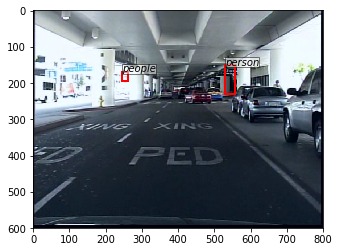

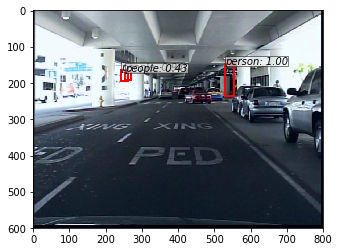

In [5]:
# User arguments
#print(opt._parse_all())

# Load dataset
dataset = TestDataset(opt, split='val')
dataloader = data_.DataLoader(dataset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False,
                                   pin_memory=True
                                   )

# Construct model
faster_rcnn = FasterRCNNVGG16(mask=opt.mask)
trainer = FasterRCNNTrainer(faster_rcnn).cuda()
trainer.load(opt.load_path)

# Predict
imgs, sizes, gt_bboxes_, gt_labels_ = next(iter(dataloader))
sizes = [sizes[0][0].item(), sizes[1][0].item()]
pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs,[sizes])

# Show score
ori_img_ = inverse_normalize(at.tonumpy(imgs[0]))
gt_img = vis_bbox(ori_img_,
                     at.tonumpy(gt_bboxes_[0]),
                     at.tonumpy(gt_labels_[0]))
plt.show()

pred_img = vis_bbox(ori_img_,
                    at.tonumpy(pred_bboxes_[0]),
                    at.tonumpy(pred_labels_[0]).reshape(-1),
                    at.tonumpy(pred_scores_[0])
                    )
plt.show()